In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import shap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn_pandas import DataFrameMapper
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
X, y = shap.datasets.california()

In [ ]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (20640, 8)
Shape of y: (20640,)


In [ ]:
print("First few rows of X:\n", X.head())
print("First few elements of y:\n", y[:5])

First few rows of X:
    MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  
0    -122.23  
1    -122.22  
2    -122.24  
3    -122.25  
4    -122.25  
First few elements of y:
 [4.526 3.585 3.521 3.413 3.422]


In [ ]:
print(f"Mean value of median income  (in $ thousand): {round(y.mean(), 1)}")

Mean value of median income  (in $ thousand): 2.1


In [ ]:
X_df = pd.DataFrame(X, columns=[
    'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms',
    'Population', 'AveOccup', 'Latitude', 'Longitude'
])

# Calculate the median for the 'MedInc' column
median_MedInc = X_df['MedInc'].median()

# Calculate the median for the target column (median house value)
median_house_value = pd.Series(y).median()

print("Median value of 'MedInc':", median_MedInc)
print("Median house value:", median_house_value)

Median value of 'MedInc': 3.5347999999999997
Median house value: 1.797


**LINEAR REGRESSION**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

In [ ]:
# Define categorical and numerical features
categorical_features = []  # Update this list if 'CHAS' is not categorical
numerical_features = [c for c in X_train.columns if c not in categorical_features]



In [ ]:
# Define transformers for numerical features
num_transformer = [([n], [SimpleImputer(), StandardScaler()]) for n in numerical_features]

In [ ]:
# Combine transformers
mapper = DataFrameMapper(num_transformer, df_out=True)



In [ ]:
# Fit and transform training data
preprocessed_X_train = mapper.fit_transform(X_train)
preprocessed_X_train = sm.add_constant(preprocessed_X_train)

# Fit the linear regression model
reg = sm.OLS(y_train, preprocessed_X_train).fit()

In [ ]:
# Define the evaluation function
def evaluate(X, y, mapper=None, reg=None, transform=False):
    if transform:
        X = mapper.transform(X)
        X = sm.add_constant(X, has_constant='add')
    y_pred = reg.predict(X)
    return mean_absolute_error(y, y_pred)

# Evaluate the model on training and testing sets
train_mae = evaluate(X_train, y_train, mapper, reg, True)
test_mae = evaluate(X_test, y_test, mapper, reg, True)

In [ ]:
print(f"Train MAE = {round(train_mae, 3)}, Test MAE = {round(test_mae, 3)}")

Train MAE = 0.543, Test MAE = 0.435


*Train MAE of 0.543: On average, the model's predictions for the median house value on the training set are off by approximately $543.
Test of 0.435: On average, the model's predictions for the median house value on the testing set are off by approximately $435.*

In [ ]:
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.599
Model:                            OLS   Adj. R-squared:                  0.599
Method:                 Least Squares   F-statistic:                     3462.
Date:                Sun, 17 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:06:32   Log-Likelihood:                -20753.
No. Observations:               18576   AIC:                         4.152e+04
Df Residuals:                   18567   BIC:                         4.160e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.1203      0.005    390.666      0.000       2.110       2.131
MedInc         0.8550      0.009     99.349      0.000       0.838       0.872
HouseAge       0.1247      0.006     20.528      0.000       0.113       0.137
AveRooms      -0.2896      0.016    -18.039      0.000      -0.321      -0.258
AveBedrms      0.3306      0.015     22.514      0.000       0.302       0.359
Population    -0.0019      0.006     -0.334      0.738      -0.013       0.009
AveOccup      -0.0342      0.005     -6.268      0.000      -0.045      -0.023
Latitude      -0.8905      0.017    -53.016      0.000      -0.923      -0.858
Longitude     -0.8902      0.017    -53.347      0.000      -0.923      -0.858
==============================================================================
Omnibus:                     3814.037   Durbin-Watson:                   0.877
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12335.113
Skew:                           1.041   Prob(JB):                         0.00
Kurtosis:                       6.406   Cond. No.                         6.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Define categorical and numerical features
categorical_features = ['CHAS'] if 'CHAS' in X_train.columns else []
numerical_features = [c for c in X_train.columns if c not in categorical_features]

# Preprocessing pipeline for numerical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features (if 'CHAS' is present)
categorical_pipeline = Pipeline([
    ('encoder', OrdinalEncoder())
]) if 'CHAS' in X_train.columns else None

# Combine preprocessing pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features) if categorical_pipeline else ('drop', 'drop', categorical_features)
], remainder='passthrough')

# Define the RandomForestRegressor model
reg = RandomForestRegressor()

# Create the main pipeline with preprocessing and regression
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('reg', reg)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Define the evaluation function
def evaluate(X, y, reg):
    y_pred = reg.predict(X)
    return mean_absolute_error(y, y_pred)

# Evaluate the model on training and testing sets
train_mae = evaluate(X_train, y_train, reg=pipeline)
test_mae = evaluate(X_test, y_test, reg=pipeline)

print(f"Train MAE = {round(train_mae, 3)}, Test MAE = {round(test_mae, 3)}")


Train MAE = 0.12, Test MAE = 0.338


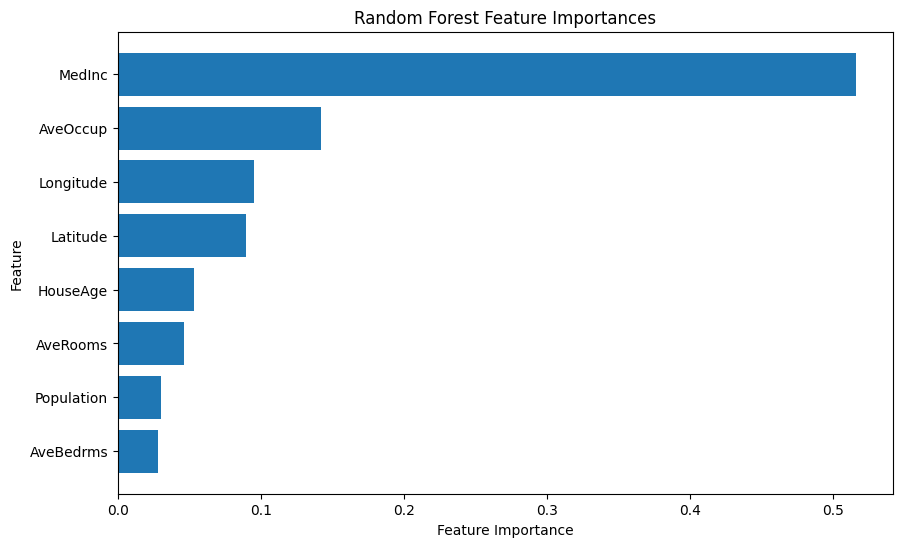

In [ ]:
import matplotlib.pyplot as plt

# Get feature importances from the trained model
feature_importances = pipeline.named_steps['reg'].feature_importances_

# Get the sorted indices of feature importances
sorted_idx = feature_importances.argsort()

# Combine numerical and categorical feature names
features = numerical_features + categorical_features

# Create a sorted list of feature names and importances
sorted_features = [features[i] for i in sorted_idx]
sorted_importances = [feature_importances[i] for i in sorted_idx]

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importances')
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import numpy as np

# Assuming X and y are loaded with the dataset

# Preprocessing pipeline for numerical features
numerical_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

# Combine preprocessing pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features)
], remainder='passthrough')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Preprocess the data
preprocessed_X_train = preprocessor.fit_transform(X_train)
preprocessed_X_test = preprocessor.transform(X_test)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(preprocessed_X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().view(-1, 1)
X_test_tensor = torch.from_numpy(preprocessed_X_test).float()

# Model definition
input_dim = X_train_tensor.shape[1]
hidden_size = 32
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 1)
)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 50
batch_size = 50
batch_no = X_train_tensor.shape[0] // batch_size

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(X_train_tensor[start:end])
        y_batch = Variable(y_train_tensor[start:end])
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {running_loss}")

# Evaluation
model.eval()
y_pred_train = model(X_train_tensor).detach().numpy().flatten()
train_mae = mean_absolute_error(y_train, y_pred_train)

y_pred_test = model(X_test_tensor).detach().numpy().flatten()
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"Train MAE = {round(train_mae, 3)}, Test MAE = {round(test_mae, 3)}")



Epoch 0, Loss: 310.43185803852975
Epoch 10, Loss: 154.57062931731343
Epoch 20, Loss: 149.04571044817567
Epoch 30, Loss: 144.5414967611432
Epoch 40, Loss: 139.29931095987558
Train MAE = 0.443, Test MAE = 0.389


NEURAL NETWORKS

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Assuming X and y are loaded with the dataset

# Preprocessing pipeline for numerical features
numerical_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

# Combine preprocessing pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features)
], remainder='passthrough')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Preprocess the data
preprocessed_X_train = preprocessor.fit_transform(X_train)
preprocessed_X_test = preprocessor.transform(X_test)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(preprocessed_X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().view(-1, 1)
X_test_tensor = torch.from_numpy(preprocessed_X_test).float()

# Model definition
input_dim = X_train_tensor.shape[1]
hidden_size = 64  # Increased hidden layer size
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, 1)
)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Decreased learning rate

# Training loop
num_epochs = 100  # Increased number of epochs
batch_size = 32  # Decreased batch size
batch_no = X_train_tensor.shape[0] // batch_size

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(X_train_tensor[start:end])
        y_batch = Variable(y_train_tensor[start:end])
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {running_loss}")

# Evaluation
model.eval()
y_pred_train = model(X_train_tensor).detach().numpy().flatten()
train_mae = mean_absolute_error(y_train, y_pred_train)

y_pred_test = model(X_test_tensor).detach().numpy().flatten()
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"Train MAE = {round(train_mae, 3)}, Test MAE = {round(test_mae, 3)}")


Epoch 0, Loss: 728.3946827352047
Epoch 10, Loss: 227.38265654072165
Epoch 20, Loss: 208.7371667381376
Epoch 30, Loss: 201.8587296968326
Epoch 40, Loss: 197.49936234531924
Epoch 50, Loss: 193.18387969769537
Epoch 60, Loss: 189.6299352608621
Epoch 70, Loss: 188.54168193694204
Epoch 80, Loss: 186.66926586953923
Epoch 90, Loss: 185.64077269565314
Train MAE = 0.414, Test MAE = 0.405


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# Assuming X and y are loaded with the dataset

# Preprocessing pipeline for numerical features
numerical_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

# Combine preprocessing pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features)
], remainder='passthrough')

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Preprocess the data
preprocessed_X_train = preprocessor.fit_transform(X_train)
preprocessed_X_test = preprocessor.transform(X_test)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(preprocessed_X_train).float()
y_train_tensor = torch.from_numpy(y_train).float().view(-1, 1)
X_test_tensor = torch.from_numpy(preprocessed_X_test).float()

# Model definition with increased complexity
input_dim = X_train_tensor.shape[1]
hidden_size1 = 64
hidden_size2 = 32
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size1),
    nn.ReLU(),
    nn.Linear(hidden_size1, hidden_size2),
    nn.ReLU(),
    nn.Linear(hidden_size2, 1)
)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adjusted learning rate

# Training loop
num_epochs = 100
batch_size = 32
batch_no = X_train_tensor.shape[0] // batch_size

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(X_train_tensor[start:end])
        y_batch = Variable(y_train_tensor[start:end])
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {running_loss}")

# Evaluation
model.eval()
y_pred_train = model(X_train_tensor).detach().numpy().flatten()
train_mae = mean_absolute_error(y_train, y_pred_train)

y_pred_test = model(X_test_tensor).detach().numpy().flatten()
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"Train MAE = {round(train_mae, 3)}, Test MAE = {round(test_mae, 3)}")


Epoch 0, Loss: 604.9630408473313
Epoch 10, Loss: 219.46918501053005
Epoch 20, Loss: 203.36846513301134
Epoch 30, Loss: 191.06447008438408
Epoch 40, Loss: 185.0009634438902
Epoch 50, Loss: 179.63588865846395
Epoch 60, Loss: 176.28768681641668
Epoch 70, Loss: 174.00246609840542
Epoch 80, Loss: 168.77003096416593
Epoch 90, Loss: 166.2609772607684
Train MAE = 0.44, Test MAE = 0.427


train MAE = 0.44, test MAE = 0.427
We don't have a direct way to identify feature importance for neural networks

Problems with Interpretation
No specific method to define feature importance that is model agnostic
For a given sample, why does the prediction have that value?
**Answer: Shap values**

In [ ]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Define categorical and numerical features
categorical_features = ['CHAS'] if 'CHAS' in X_train.columns else []
numerical_features = [c for c in X_train.columns if c not in categorical_features]

# Preprocessing pipeline for numerical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features (if 'CHAS' is present)
categorical_pipeline = Pipeline([
    ('encoder', OrdinalEncoder())
]) if 'CHAS' in X_train.columns else None

# Combine preprocessing pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features) if categorical_pipeline else ('drop', 'drop', categorical_features)
], remainder='passthrough')

# Define the LinearRegression model
reg = LinearRegression()

# Create the main pipeline with preprocessing and regression
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('reg', reg)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Define the evaluation function
def evaluate(X, y, reg):
    y_pred = reg.predict(X)
    return mean_absolute_error(y, y_pred)

# Evaluate the model on training and testing sets
train_mae = evaluate(X_train, y_train, reg=pipeline)
test_mae = evaluate(X_test, y_test, reg=pipeline)

print(f"Train MAE = {round(train_mae, 3)}, Test MAE = {round(test_mae, 3)}")


Train MAE = 0.543, Test MAE = 0.435


In [ ]:
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Assuming X and y are defined and contain your data

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Define categorical and numerical features
categorical_features = ['CHAS'] if 'CHAS' in X_train.columns else []
numerical_features = [c for c in X_train.columns if c not in categorical_features]

# Preprocessing pipeline for numerical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical features (if 'CHAS' is present)
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('encoder', OrdinalEncoder())
]) if 'CHAS' in X_train.columns else None

# Combine preprocessing pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features) if categorical_pipeline else ('drop', 'drop', categorical_features)
])

# Define the LinearRegression model
reg = LinearRegression()

# Create the main pipeline with preprocessing and regression
pipeline = Pipeline([
    ('preprocess', preprocessor),
    ('reg', reg)
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['MedInc', 'HouseAge',
                                                   'AveRooms', 'AveBedrms',
                                                   'Population', 'AveOccup',
                                                   'Latitude', 'Longitude']),
                                                 ('drop', 'drop', [])])),
                ('reg', LinearRegression())])

**Intuition of Model Interpretation**


How we think about answering the question "Why is the output for this specific sample so low/high" manually?

In [ ]:
import pandas as pd

# Define categorical and numerical features
categorical_features = ['CHAS']  # Example categorical feature
numerical_features = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']  # Example numerical features

# Create an empty DataFrame with specified columns and index
nan_frame = pd.DataFrame(columns=categorical_features + numerical_features, index=[0])

print(nan_frame)


  CHAS MedInc HouseAge AveRooms AveBedrms Population AveOccup Latitude  \
0  NaN    NaN      NaN      NaN       NaN        NaN      NaN      NaN   

  Longitude  
0       NaN  


In [ ]:
base_value = round(pipeline.predict(nan_frame)[0], 3)
print(f"Expected value of the output (base value): {base_value}")

Expected value of the output (base value): 2.12


In [ ]:
X_test.iloc[0: 1]

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
18576,2.0775,44.0,3.053156,1.026578,1321.0,4.388704,36.9,-121.76


In [ ]:
sample_prediction = round(pipeline.predict(X_test.iloc[0: 1])[0], 3)
print(f"Current Prediction: {sample_prediction}, Actual value: {y_test[0]}")

Current Prediction: 2.081, Actual value: 1.214


In [ ]:
sample_prediction = round(pipeline.predict(X_test.iloc[0:1])[0], 3)
print(f"Current Prediction: {sample_prediction}, Actual value: {y_test[0]}")


Current Prediction: 2.081, Actual value: 1.214


How did we get from 2.081?

Find this by adjusting individual feature values. But this can be hard to look at
Fast way to visualize is with Partial Dependency Plots (which uses Shap values for individual samples)
Shap values assign a contributing factor to every feature of every sample

In [ ]:
from sklearn.metrics import mean_absolute_error

# Predict using the trained pipeline on the test set
y_pred = pipeline.predict(X_test)

# Calculate the mean absolute error
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {round(mae, 3)}")


Mean Absolute Error (MAE): 0.435


In [ ]:
explainer = shap.Explainer(pipeline.predict, X_train)
shap_values = explainer(X_test)

ExactExplainer explainer: 2065it [01:22, 22.16it/s]                          


**Partial Dependence Plots**

In [ ]:
def partial_dependence_plot(feature, idx=None):
    if idx is None: # visualize all samples
        shap.plots.partial_dependence(
            feature,
            pipeline.predict,
            X_train,
            ice=False,
            model_expected_value=True,
            feature_expected_value=True)
    else: # visualize sample idx
        shap.partial_dependence_plot(
            feature,
            pipeline.predict,
            X_train,
            ice=False,
            model_expected_value=True,
            feature_expected_value=True,
            shap_values=shap_values[idx:idx+1,:])

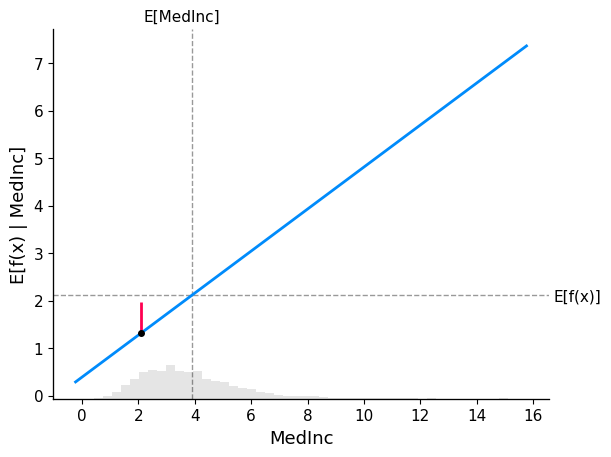

In [ ]:
partial_dependence_plot('MedInc', 0)

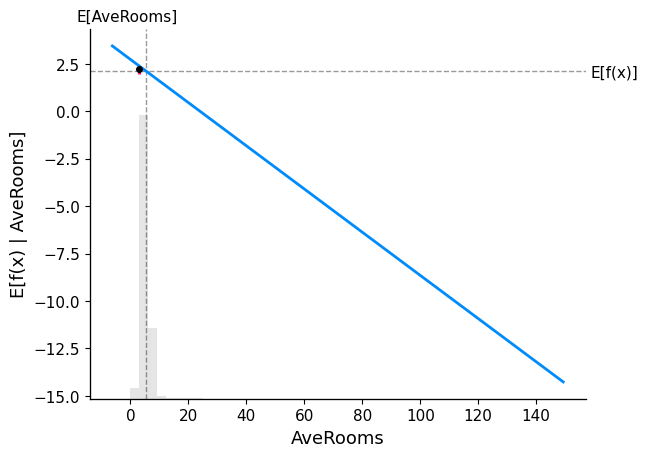

In [ ]:
partial_dependence_plot('AveRooms', 0)

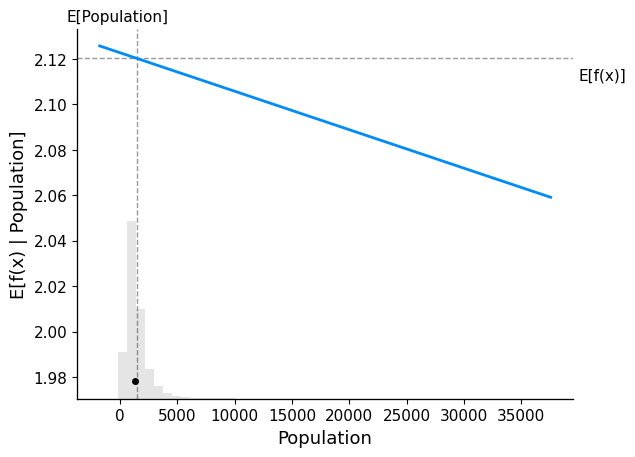

In [ ]:
partial_dependence_plot('Population', 0)

In [ ]:
shap.initjs()

**Shap Plots**



Hard to look at every feature for every sample. So lets look at all features of the same sample

In [ ]:
def sample_feature_importance(idx, type='condensed'):
    if type == 'condensed':
        return shap.plots.force(shap_values[idx])
    elif type == 'waterfall':
        return shap.plots.waterfall(shap_values[idx])
    else:
        return "Return valid visual ('condensed', 'waterfall')"

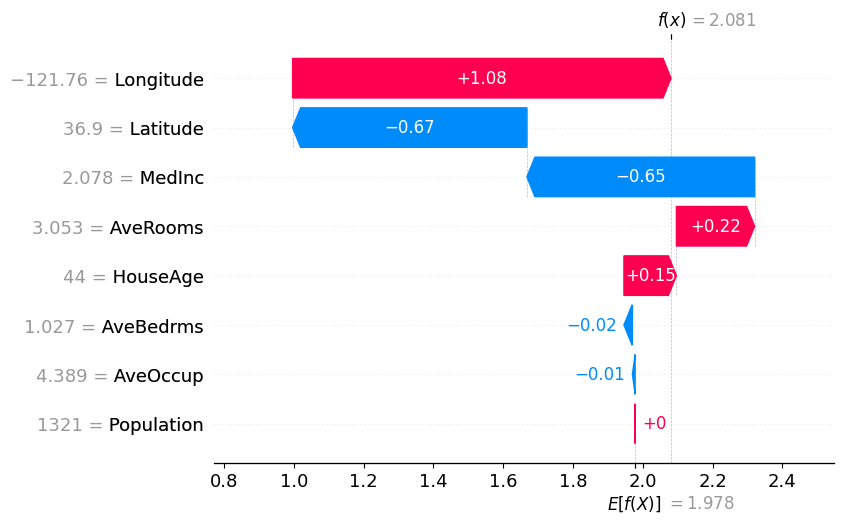

In [ ]:
sample_feature_importance(0, 'waterfall')

In [ ]:
sample_feature_importance(0, 'condensed')

**Feature Importance for model**


Looking at individual samples can be a bother. Let's look at all samples together

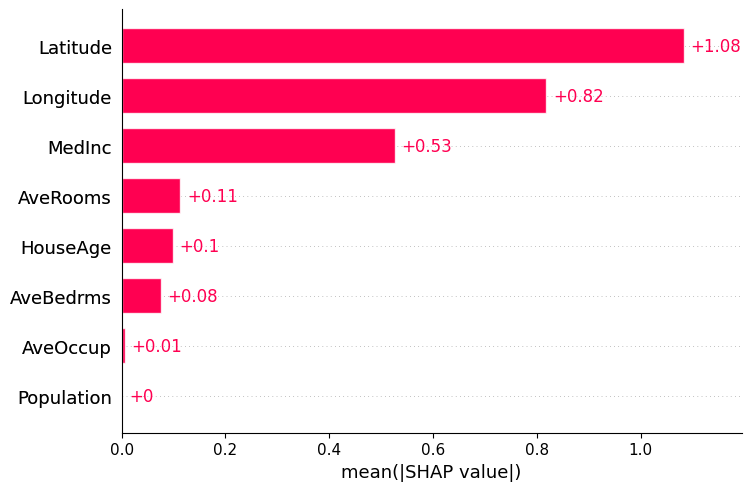

In [ ]:
shap.plots.bar(shap_values)

Two most important features according to the LinearRegression model:

Lattitude: index of accessibility
Logitutde: Index of location

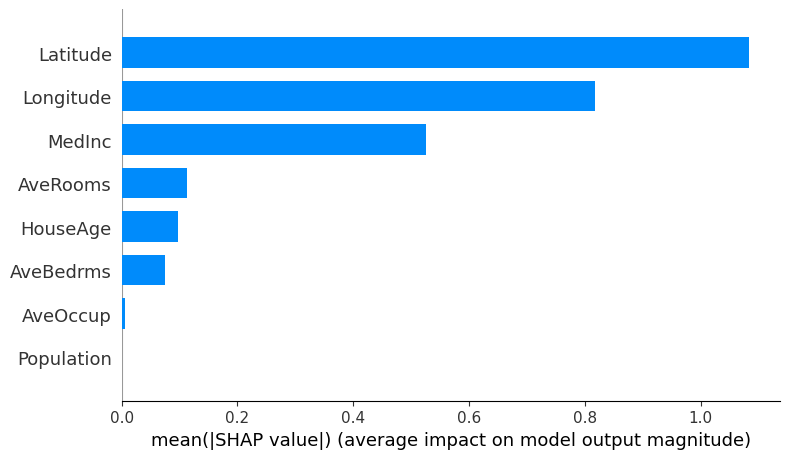

In [ ]:
shap.summary_plot(shap_values.values, X_train, plot_type='bar')

In [ ]:
preprocessed_X_train = mapper.fit_transform(X_train)

num_epochs = 50
learning_rate = 0.01
hidden_size = 32
batch_size = 50
input_dim = preprocessed_X_train.shape[1]
batch_no = preprocessed_X_train.shape[0] // batch_size
model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.Linear(hidden_size, 1)
)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(torch.FloatTensor(preprocessed_X_train.values[start:end]))
        y_batch = Variable(torch.FloatTensor(y_train[start:end]))
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, torch.unsqueeze(y_batch,dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0:
        print("Epoch {}, Loss: {}".format(epoch, running_loss))

preprocessed_X_test = mapper.transform(X_test)
y_pred = model(torch.from_numpy(preprocessed_X_test.values).float()).flatten().detach().numpy()
test_mae = mean_absolute_error(y_test, y_pred)
preprocessed_X_train = mapper.transform(X_train)
y_pred = model(torch.from_numpy(preprocessed_X_train.values).float()).flatten().detach().numpy()
train_mae = mean_absolute_error(y_train, y_pred)
print(f"\ntrain MAE = {round(train_mae, 3)}, test MAE = {round(test_mae, 3)} ")

Epoch 0, Loss: 399.0715828128159
Epoch 10, Loss: 246.73452515900135
Epoch 20, Loss: 220.83158817887306
Epoch 30, Loss: 223.53665699064732
Epoch 40, Loss: 219.44747937470675

train MAE = 0.571, test MAE = 0.473 


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import pandas as pd

# Assuming X_train and y_train are already defined

# Define categorical and numerical features
categorical_features = ['CHAS'] if 'CHAS' in X_train.columns else []
numerical_features = [c for c in X_train.columns if c not in categorical_features]

# Create preprocessing pipelines for numerical and categorical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # You can change the imputation strategy as needed
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # You can change the imputation strategy as needed
    ('encoder', OrdinalEncoder())
]) if 'CHAS' in X_train.columns else None

# Combine preprocessing pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features) if categorical_pipeline else ('drop', 'drop', categorical_features)
], remainder='passthrough')

# Fit and transform the preprocessor on the training data
try:
    preprocessed_X_train = preprocessor.fit_transform(X_train)
except KeyError as e:
    print(f"KeyError: {e} not found in columns. Check your data or preprocessing steps.")

# Example usage of the preprocessed data
print(preprocessed_X_train)

[[ 2.28089511  0.93861316  0.62154557 ... -0.07653651  1.18837163
  -1.4151571 ]
 [ 2.26857987 -0.64135667  0.32826005 ... -0.14986292  1.17866917
  -1.41014058]
 [ 1.72836531  1.80759657  1.13421584 ... -0.03595005  1.17381794
  -1.42017362]
 ...
 [-1.01229219 -0.48335969 -0.79006144 ...  0.09765254  0.71780213
  -1.17938067]
 [-0.70234149  1.01761165 -1.01304431 ...  0.28890038  0.71780213
  -1.17436415]
 [-0.56009534 -1.66833706 -0.63762953 ...  0.09419001  0.71780213
  -1.18439719]]


**We can interpret the neural network model in the same way**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

# Assuming X_train and y_train are already defined

# Define categorical and numerical features
categorical_features = ['CHAS'] if 'CHAS' in X_train.columns else []
numerical_features = [c for c in X_train.columns if c not in categorical_features]

# Create preprocessing pipelines for numerical and categorical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # You can change the imputation strategy as needed
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # You can change the imputation strategy as needed
    ('encoder', OrdinalEncoder())
]) if 'CHAS' in X_train.columns else None

# Combine preprocessing pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_features),
    ('cat', categorical_pipeline, categorical_features) if categorical_pipeline else ('drop', 'drop', categorical_features)
], remainder='passthrough')

# Fit and transform the preprocessor on the training data
try:
    preprocessed_X_train = preprocessor.fit_transform(X_train)
except KeyError as e:
    print(f"KeyError: {e} not found in columns. Check your data or preprocessing steps.")

# Neural network model using PyTorch
num_epochs = 50
learning_rate = 0.01
hidden_size = 32
batch_size = 50
input_dim = preprocessed_X_train.shape[1]
batch_no = preprocessed_X_train.shape[0] // batch_size

model = nn.Sequential(
    nn.Linear(input_dim, hidden_size),
    nn.Linear(hidden_size, 1)
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_batch = Variable(torch.FloatTensor(preprocessed_X_train[start:end]))
        y_batch = Variable(torch.FloatTensor(y_train[start:end]))
        optimizer.zero_grad()
        y_preds = model(x_batch)
        loss = criterion(y_preds, torch.unsqueeze(y_batch, dim=1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 0:
        print("Epoch {}, Loss: {}".format(epoch, running_loss))

# Preprocess the test data and make predictions
preprocessed_X_test = preprocessor.transform(X_test)
y_pred = model(torch.from_numpy(preprocessed_X_test).float()).flatten().detach().numpy()

# Calculate MAE for train and test data
train_mae = mean_absolute_error(y_train, model(torch.from_numpy(preprocessed_X_train).float()).flatten().detach().numpy())
test_mae = mean_absolute_error(y_test, y_pred)

print(f"\nTrain MAE = {round(train_mae, 3)}, Test MAE = {round(test_mae, 3)}")


Epoch 0, Loss: 363.7811331897974
Epoch 10, Loss: 263.8169461116195
Epoch 20, Loss: 225.9871515929699
Epoch 30, Loss: 257.4433943964541
Epoch 40, Loss: 225.46164651960135

Train MAE = 0.825, Test MAE = 0.647


MIT License

Copyright (c) 2024 baiganas

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.